In [1]:
import numpy as np
import scipy as sp
from scipy import stats
from scipy.special import gammaln
import pandas as pd
from matplotlib import pyplot as plt

First, let's load in the data and calculate some stuff.

In [2]:
#Read in the data
S = pd.read_csv('stock_data.txt', header=None, usecols=[1], names=['Stock Price'])

#Infer the times from the fact that the last day is 15 Dec. 2018
last_day = '15 December 2018'
S['Date'] = pd.date_range(end=last_day, freq='D', periods = len(S))
S.set_index('Date', inplace=True)

#Look at the data to see if it makes sense.
S.plot()
plt.xlabel('')
plt.savefig("Stock_vs_time.png")
plt.show()
S.head()

Stock Price
Date                   
2015-12-17      10.0000
2015-12-18       9.8427
2015-12-19       9.9169
2015-12-20       9.8965
2015-12-21       9.8905

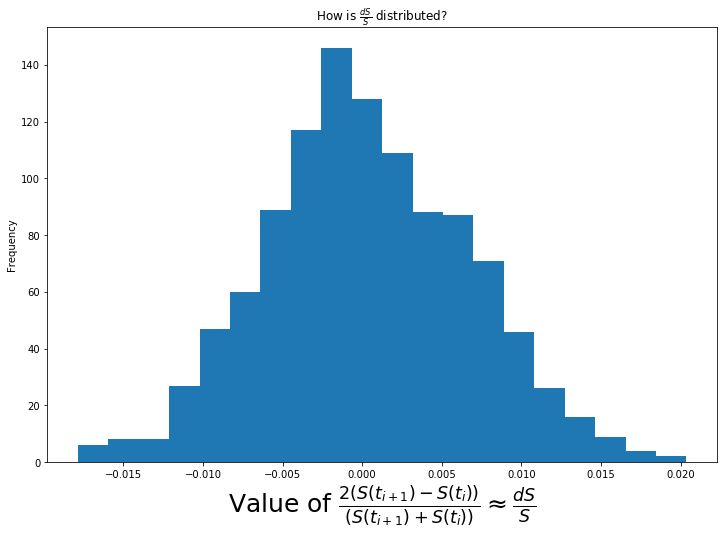

In [3]:
#Get our estimates for dS/S
prev_day = S.shift(1)
dS = S - prev_day
dS_over_S = 2 * (dS)/(prev_day + S)
dS_over_S.plot(kind='hist', bins=20, legend=None, figsize=(12, 8))
plt.title(r"How is $\frac{dS}{S}$ distributed?")
plt.xlabel(r"Value of $\frac{2  (S(t_{i+1}) - S(t_i))}{(S(t_{i+1}) + S(t_i))} \approx \frac{dS}{S}$", 
           fontsize=25)

plt.savefig("dS_over_S.png")
plt.show()


Should expect
$$
\frac{2  (S(t_{i+1}) - S(t_i))}{(S(t_{i+1}) + S(t_i))} \approx \frac{dS}{S}
= \mu dt + \sigma dW \approx \mu \cdot (t_{i+1} - t_{i}) + \sigma \cdot (W(t_{i+1}) - W(t_{i}))
$$
I don't know much about Brownian motion, but I do know that $W(t_i) - W(t_j) \sim \mathscr{N}(0, t_i - t_j)$.  Therefore, $\mu \Delta t + \sigma \cdot (W(t_{i+1}) - W(t_{i})) \sim \mathscr{N}(\mu \Delta t, \sigma^2\Delta t)$.  So, if the approximation is valid enough, ``dS_over_S`` corresponds to several draws from $\mathscr{N}(\mu, \sigma^2)$.  We can then start to estimate them with Bayesian stats.

The Wikipedia article on Conjugate Priors says that the inverse-gamma-normal is the conjugate prior for a normal distribution where neither mu nor sigma are known.

Derived my own prior in the work.  It's this:
$$
\mu, \sigma^2 
\mapsto
    \sqrt{\frac{n}{2 \pi}}
    \frac{\left(\tfrac{1}{2}\sum_{i=1}^{n}\Big(d_i - \overline{d}\Big)^2\right)^{\frac{n-3}{2}}}
        {\Gamma\left(\frac{n-3}{2}\right)}
    \left(\frac{1}{\sigma^2}\right)^{n/2} 
    \exp\left(-\tfrac{1}{2 \sigma^2} 
        \left(
        \sum_{i=1}^{n}\left(d_i - \overline{d}\right)^2 
        + n\left(\overline{d} - \mu\right)^2
        \right)
    \right).
$$

Re-arrange it a bit to make some of terms computable.
$$
    \sqrt{\frac{n}{2 \pi}}
    \frac{\left( \tfrac{1}{2\sigma^2}\sum_{i=1}^{n}\Big(d_i - \overline{d}\Big)^2\right)^{\frac{n-3}{2}}}
        {\Gamma\left(\frac{n-3}{2}\right)}
    \left(\frac{1}{\sigma^2}\right)^{3/2} 
    \exp\left(-\tfrac{1}{2 \sigma^2} 
        \left(
        \sum_{i=1}^{n}\left(d_i - \overline{d}\right)^2 
        + n\left(\overline{d} - \mu\right)^2
        \right)
    \right).
$$

Let's make a heatmap.

Sample mean: 0.000266972133996
Sample variance: 4.09452727922e-05
Sample standard deviation: 0.00639884933345
MAP for mu: 0.000264646464646 
MAP for sigma: 0.00639799526683
standard deviation / sigma_map: 1.00013348972
(standard deviaion / sigma_map)**2 1.00026699727


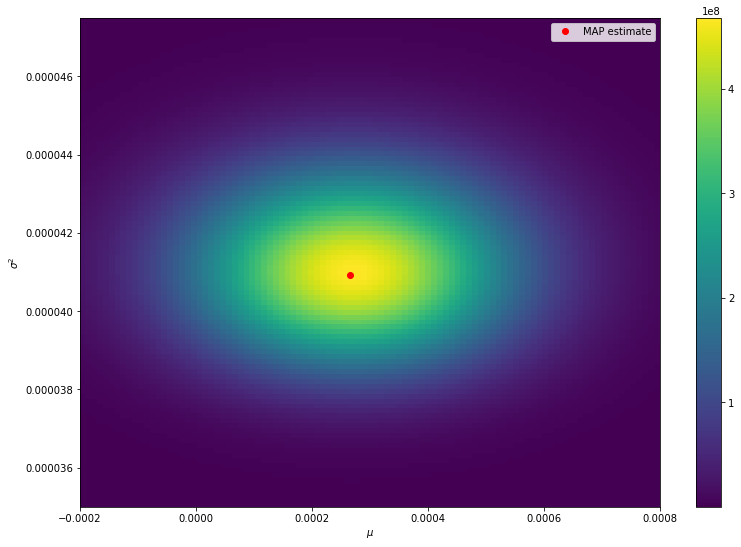

In [4]:
d = dS_over_S.dropna().values.copy().ravel()
print("Sample mean:", d.mean())
print("Sample variance:", d.var())
print("Sample standard deviation:", d.std())

class MyPosteriorDistribution():
    
    def __init__(self, data):
        self.n = data.size
        self.d = data.copy()
    
    def __call__(self, m, v):
        """
        m = mean
        v = variance
        """
        n, d = self.n, self.d
        sqd_deviations = sum((d-d.mean())**2) #This shows up twice in the pdf.
        term1 = np.sqrt(n/(2*np.pi))
        
        #This second term is a beast, and takes some wrangling to get to to not overflow.
        #term2 = (var_d/(2 *np.pi*v))**((n-3)/2) / gamma((n-3)/2)
        top_logged = ((n-3)/2)*np.log(sqd_deviations/(2 *v))
        bottom_logged = gammaln((n-3)/2)
        term2 = np.exp(top_logged - bottom_logged)
        
        term3 = (1/v)**(3/2)
        term4 = np.exp(-1/(2*v) * (sqd_deviations+ n*(d.mean() - m)**2))
        return term1 * term2 * term3 * term4

pdf = MyPosteriorDistribution(d)

mu = np.linspace(-.0002, .0008, 100)
sigma_squared = np.linspace(.000035, .0000475, 100)
M, S2 = np.meshgrid(mu, sigma_squared)
density = pdf(M, S2)

#Get the maximum a posteriori estimates.
max_a_posteriori_index = np.unravel_index(np.argmax(density), density.shape)
mu_map = M[max_a_posteriori_index]
sigma_map = np.sqrt(S2[max_a_posteriori_index])
print( "MAP for mu:",mu_map, "\nMAP for sigma:", sigma_map)
print("standard deviation / sigma_map:", d.std()/sigma_map)
print("(standard deviaion / sigma_map)**2", (d.std()/sigma_map)**2)

plt.figure(figsize=(13, 9))
plt.pcolormesh(M, S2, density, cmap="viridis")
plt.plot(mu_map, sigma_map **2, 'ro',  label="MAP estimate")
plt.xlabel(r"$\mu$")
plt.ylabel(r"$\sigma^2$")
plt.colorbar()
plt.legend()
plt.savefig("pdf.png")
plt.show()

In [5]:
#Get the stock value on December 15th.
S0 = S.values[-1]
print(S0)
#Find the number of days between 15 December 2018 and 31 December 2019
t_end = len(pd.date_range(start='16 December 2018', end='31 December 2019', freq='D'))

print(t_end)

[ 13.392]
381


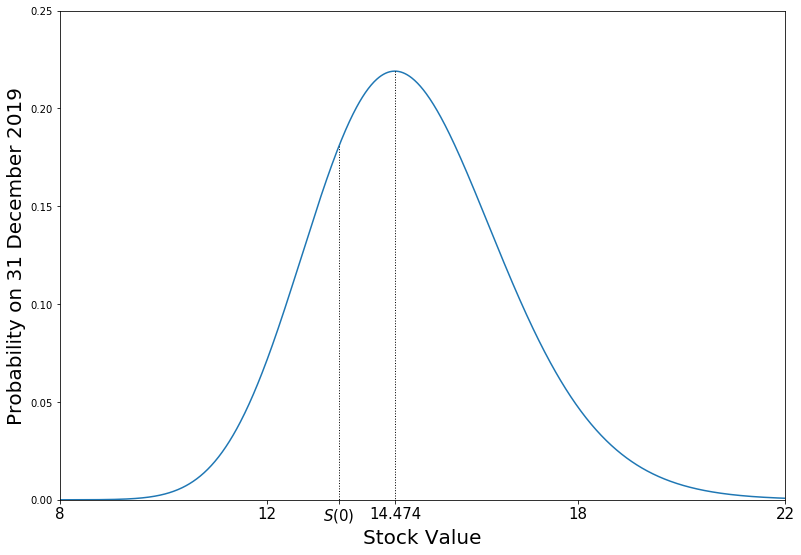

In [10]:
#Make a lognormal random variable instance.
mean = np.log(S0) + (mu_map - (sigma_map**2)/2)*t_end
std_deviation = sigma_map * np.sqrt(t_end)
S381 = stats.lognorm(s = std_deviation, scale = np.exp(mean))
x = np.linspace(8, 22, 1000)
plt.figure(figsize=(13, 9))
plt.plot(x, S381.pdf(x), label=r"p.d.f. of S(381)")

x_star = x[np.argmax(S381.pdf(x))]
plt.plot([x_star, x_star], [S381.pdf(x_star), 0], 'k:', linewidth=1)
plt.plot([S0, S0], [S381.pdf(S0), 0], 'k:', linewidth=1)
plt.xlim((x.min(), x.max()))
plt.ylim((0, .25))

new_xticks = [8, 12, S0,x_star, 18, 22]
plt.xticks(new_xticks, [8, 12, r'$S(0)$','{:.3f}'.format(x_star), 18,22], fontsize=15)
plt.xlabel("Stock Value", fontsize=20)
plt.ylabel("Probability on 31 December 2019", fontsize=20)

plt.savefig("pdf_of_31_Dec_2019.png")
plt.show()


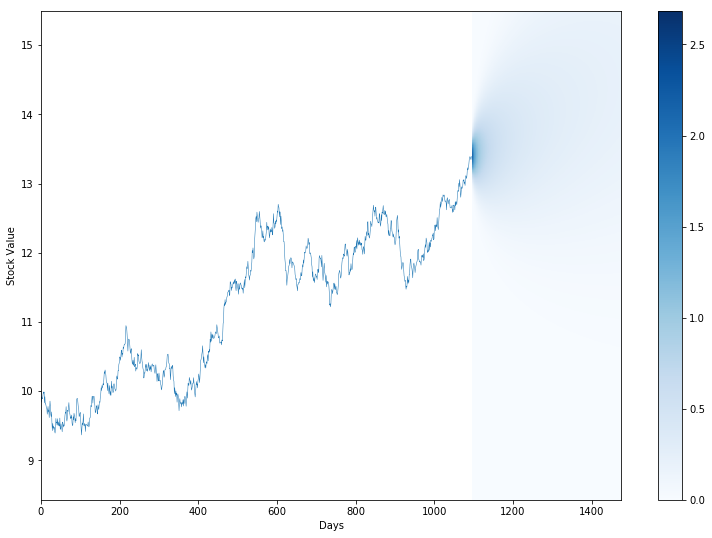

In [20]:
#Make a heat map for the Stock price.
s = S.values.ravel()
t = np.arange(len(s) + t_end)

plt.figure(figsize=(13, 9))

#Put the line for the original stock data.
plt.xlim((t.min(), t.max()))
plt.ylim((s.min()*.90, 15.5))
plt.plot(t[:len(s)], s, lw=.5)

extra_days = 1
t_future = t[len(s)+extra_days:]
s_future = np.linspace(8, 16, 1000)
T_future, S_future = np.meshgrid(t_future, s_future)

def pdf(S, T):
    #Use the explicit fomula we found in the manual.
    coeff = 1/(S*sigma_map *np.sqrt(2*np.pi*T))
    numerator = (np.log(S/S0) - (mu_map - ((sigma_map)**2)/2)*T)**2
    denominator = 2*T*sigma_map**2
    return coeff * np.exp(- numerator / denominator)
                          
T_shifted = T_future - t[len(S)-1-extra_days] #Account for shift in start time.
plt.pcolormesh(T_future, S_future, pdf(S_future, T_shifted), cmap='Blues')
plt.colorbar()
plt.xlabel("Days")
plt.ylabel("Stock Value")
plt.savefig("diffusion after day 1.png")

plt.show()

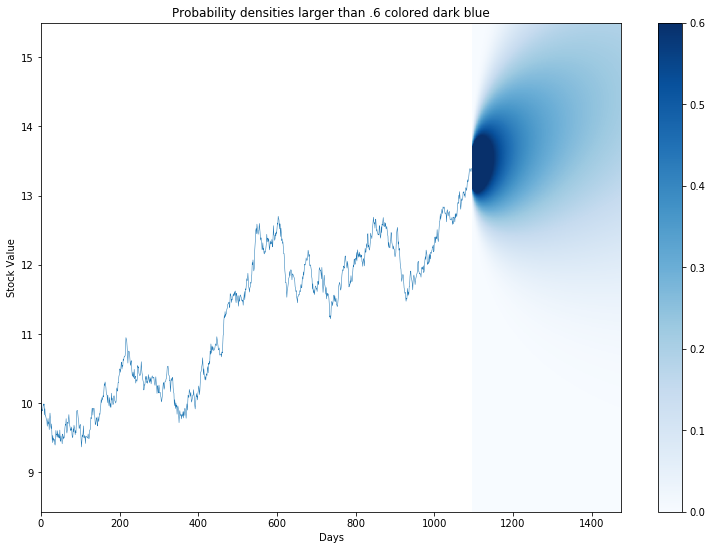

In [21]:
plt.figure(figsize=(13, 9))

#Put the line for the original stock data.
plt.xlim((t.min(), t.max()))
plt.ylim((s.min()*.90, 15.5))
plt.plot(t[:len(s)], s, lw=.5)

extra_days = 1
t_future = t[len(s)+extra_days:]
s_future = np.linspace(8, 16, 1000)
T_future, S_future = np.meshgrid(t_future, s_future)

T_shifted = T_future - t[len(S)-1-extra_days] #Account for shift in start time.
plt.pcolormesh(T_future, S_future, pdf(S_future, T_shifted), cmap='Blues', vmax=.6)
plt.colorbar()
plt.xlabel("Days")
plt.ylabel("Stock Value")

plt.title("Probability densities larger than .6 colored dark blue")
plt.savefig("diffusion after 30 days.png")

plt.show()